### Draw Stellar Locus by matching the sources found in 3 different bands and comparing their magnitudes. The matching is done on the full focal plane (36 CCD)

In [27]:
import lsst.daf.persistence as dafPersist
import lsst.afw.cameraGeom as cg
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
import lsst.afw.table as afwTable
import math

def getMagnitude(mRef, visit, filter) :
    # retrieve the CCD corresponding to the reference source
    ccdRef = mRef.get('ccd')
    # retrieve the calibration object associated to the CCD
    did = {'visit':visit, 'filter':filter, 'ccd':ccdRef}
    md = butler.get("calexp_md", did, immediate=True)
    calib = afwImage.Calib(md)
    # compute magnitude
    flux = mRef.get('base_SincFlux_flux')
    if flux > 0 :
        return calib.getMagnitude(mRef.get('base_SincFlux_flux'))
    else :
        return 999.0

def createFullFPCatalog(butler, visit, filter) :

    for ccd in range(36) :
        dataid = {'visit':visit, 'filter':filter, 'ccd':ccd}
        oldSrc = butler.get('src', dataid, immediate=True)
#        print ccd, len(oldSrc)
        if ccd == 0 :
            # retrieve the schema of the source catalog and extend it in order to add a field to record the ccd number
            oldSchema = oldSrc.getSchema()
            mapper = afwTable.SchemaMapper(oldSchema)
            mapper.addMinimalSchema(oldSchema)
            newSchema = mapper.getOutputSchema()
            newSchema.addField("ccd", type=int, doc="CCD number")
            
            #create the new extented source catalog 
            srcRef = afwTable.SourceCatalog(newSchema)
        
        # create temporary catalog
        tmpCat = afwTable.SourceCatalog(srcRef.table)
        tmpCat.extend(oldSrc, mapper=mapper)
        # fill in the ccd information in numpy mode in order to be efficient
        tmpCat['ccd'][:] = ccd
        # append the temporary catalog to the extended source catalog    
        srcRef.extend(tmpCat, deep=False)
    
    return srcRef
    
    
visits = [906675, 918231, 832860]

Flags = ["base_PixelFlags_flag_saturated", "base_PixelFlags_flag_cr", "base_PixelFlags_flag_interpolated",
         "base_PsfFlux_flag_edge"]

#setup butler - Replace path name by something suitable for you
butler = dafPersist.Butler("/home/boutigny/CFHT/test_cfht/output")

src_r = createFullFPCatalog(butler, visits[0], 'r')
print len(src_r), " r sources"
src_g = createFullFPCatalog(butler, visits[1], 'g')
print len(src_g), "g sources"
src_i = createFullFPCatalog(butler, visits[2], 'i')
print len(src_i), "i sources"

src_g.sort()

match_rg = afwTable.matchRaDec(src_r, src_g, afwGeom.Angle(1./3600., afwGeom.degrees))
print "r-g :", len(match_rg), "matches found"
match_ri = afwTable.matchRaDec(src_r, src_i, afwGeom.Angle(1./3600., afwGeom.degrees))
print "r-i :", len(match_ri), "matches found"

rMinusi_s = []
gMinusr_s = []
rMinusi_g = []
gMinusr_g = []

nMatchStars = 0

for cnts, m in enumerate(match_ri) :
    if float(cnts)//10000 == float(cnts)/10000 :
        print cnts
    m_r = m.first
    m_i = m.second
    mag_r = getMagnitude(m_r,visits[0],'r')
    if mag_r > 21 :
        continue
    
    for f in Flags :
        if m_r.get(f) or m_i.get(f) :
            continue
        
    # Select galaxies
    if m_r.get("base_ClassificationExtendedness_value") >= 1.0 or m_i.get("base_ClassificationExtendedness_value") >= 1.0 :
        gal = 1
        star = 0
    # Select stars
    elif m_r.get("base_ClassificationExtendedness_value") < 1.0 and m_i.get("base_ClassificationExtendedness_value") < 1.0 :
        star = 1
        gal = 0
    else :
        gal = 0
        star = 0
        continue
            
    # Check if we find a corresponding matching in r_g
    # There is probably a better / faster way of doing that ==> need some investigation

    rId = m_r.getId()
    for m2 in match_rg :
        m_r2 = m2.first
        if m_r2.getId() == rId :
            m_g2 = m2.second
            mag_g = getMagnitude(m_g2,visits[1],'g')
            mag_i = getMagnitude(m_i,visits[2],'i')
            if star == 1 :
                rMinusi_s.append(mag_r-mag_i)
                gMinusr_s.append(mag_g-mag_r)
                nMatchStars +=1
            if gal == 1 :
                rMinusi_g.append(mag_r-mag_i)
                gMinusr_g.append(mag_g-mag_r)
            
            break            
            
print "Number of matched stars", nMatchStars

67950  r sources
74246 g sources
62390 i sources
r-g : 42904 matches found
r-i : 47590 matches found
0
10000
20000
30000
40000
Number of matched stars 1440


In [48]:
print dir(match_ri)
for n, m in enumerate(match_ri) :
    if n < 1 :
        print dir(m)
        k = m

['__add__', '__class__', '__contains__', '__delattr__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__getslice__', '__gt__', '__hash__', '__init__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'count', 'index']
['__class__', '__del__', '__delattr__', '__dict__', '__doc__', '__format__', '__getattr__', '__getattribute__', '__getitem__', '__getstate__', '__hash__', '__init__', '__len__', '__module__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__swig_destroy__', '__swig_getmethods__', '__swig_setmethods__', '__weakref__', 'clone', 'distance', 'first', 'second', 'this']


In [45]:
print match_ri.count(k)

1


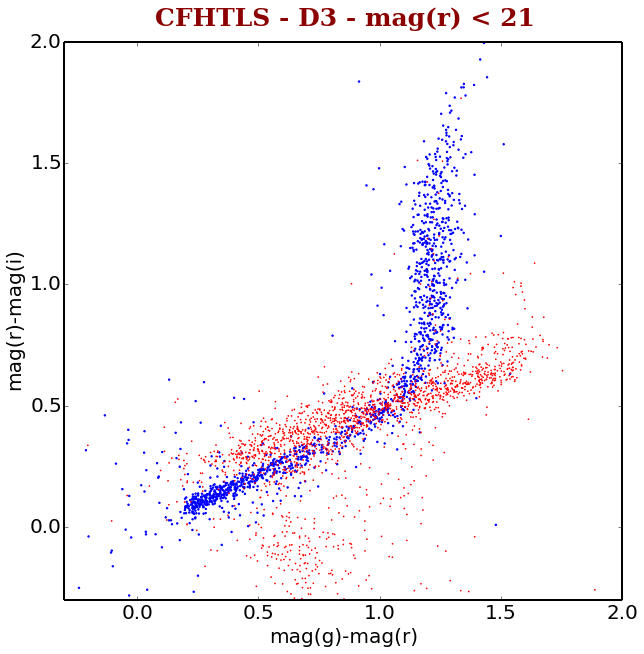

In [29]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'bold',
        'size'   : 25,
        }

plt.clf()
plt.rcParams['axes.linewidth'] = 2 #set the value globally
fig, (ax0) = plt.subplots(ncols=1, figsize=(10,10))
ax0.scatter(gMinusr_s, rMinusi_s, s=2, color='b')
ax0.scatter(gMinusr_g, rMinusi_g, s=0.5, color='r')
ax0.set_xlim([-0.3,2.0])
ax0.set_ylim([-0.3,2.0])
ax0.set_ylabel("mag(r)-mag(i)", fontsize=20, weight='normal')
ax0.set_xlabel("mag(g)-mag(r)", fontsize=20, weight='normal')
ax0.set_title("CFHTLS - D3 - mag(r) < 21", fontdict=font, y=1.02)
ax0.tick_params(labelsize=20)
plt.rcParams['axes.linewidth'] = 0.5 #set the value globally
plt.show()

In [4]:
import lsst.daf.persistence as dafPersist
import lsst.afw.cameraGeom as cg
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
import lsst.afw.table as afwTable
import math

def getMagnitude(mRef, visit, filter) :
    
    # Check that flux is positive
    flux = mRef.get('base_SincFlux_flux')
    if flux < 0 :
        return 999
    
    # retrieve the CCD corresponding to the reference source
    ccdRef = mRef.get('ccd')
    # retrieve the calibration object associated to the CCD
    did = {'visit':visit, 'filter':filter, 'ccd':ccdRef}
    md = butler.get("calexp_md", did, immediate=True)
    calib = afwImage.Calib(md)
    # compute magnitude
    return calib.getMagnitude(flux)

def createFullFPCatalog(butler, visit, filter) :

    for ccd in range(36) :
        dataid = {'visit':visit, 'filter':filter, 'ccd':ccd}
        oldSrc = butler.get('src', dataid, immediate=True)
#        print ccd, len(oldSrc)
        if ccd == 0 :
            # retrieve the schema of the source catalog and extend it in order to add a field to record the ccd number
            oldSchema = oldSrc.getSchema()
            mapper = afwTable.SchemaMapper(oldSchema)
            mapper.addMinimalSchema(oldSchema)
            newSchema = mapper.getOutputSchema()
            newSchema.addField("ccd", type=int, doc="CCD number")
            
            #create the new extented source catalog 
            srcRef = afwTable.SourceCatalog(newSchema)
        
        # create temporary catalog
        tmpCat = afwTable.SourceCatalog(srcRef.table)
        tmpCat.extend(oldSrc, mapper=mapper)
        # fill in the ccd information in numpy mode in order to be efficient
        tmpCat['ccd'][:] = ccd
        # append the temporary catalog to the extended source catalog    
        srcRef.extend(tmpCat, deep=False)
    
    return srcRef
    
    
visits = [906675, 906805, 918231]

Flags = ["base_PixelFlags_flag_saturated", "base_PixelFlags_flag_cr", "base_PixelFlags_flag_interpolated",
         "base_PsfFlux_flag_edge"]

#setup butler - Replace path name by something suitable for you
butler = dafPersist.Butler("/home/boutigny/CFHT/test_cfht/output")

src_r = createFullFPCatalog(butler, visits[0], 'r')
print len(src_r), " r sources"
src_u = createFullFPCatalog(butler, visits[1], 'u')
print len(src_u), "u sources"
src_g = createFullFPCatalog(butler, visits[2], 'g')
print len(src_g), "g sources"

src_g.sort()

match_gr = afwTable.matchRaDec(src_g, src_r, afwGeom.Angle(1./3600., afwGeom.degrees))
print "g-r :", len(match_gr), "matches found"
match_ug = afwTable.matchRaDec(src_u, src_g, afwGeom.Angle(1./3600., afwGeom.degrees))
print "u-g :", len(match_ug), "matches found"

gMinusr_s = []
uMinusg_s = []
gMinusr_g = []
uMinusg_g = []
mu_g = []
mg_g = []
mi_g = []
mu_s = []
mg_s = []
mr_s = []

for cnts, m in enumerate(match_gr) :
    
#    if cnts > 100 :
#        break
    if float(cnts)//10000 == float(cnts)/10000 :
        print cnts
    m_g = m.first
    m_r = m.second
    mag_r = getMagnitude(m_r,visits[0],'r')
    if mag_r > 21 :
        continue
    
    for f in Flags :
        if m_r.get(f) or m_g.get(f) :
            continue
        
    # Select galaxy like objects
    if m_r.get("base_ClassificationExtendedness_value") >= 1.0 or m_g.get("base_ClassificationExtendedness_value") >= 1.0 :
        gal = 1
        star = 0
    # Select star like object
    elif m_r.get("base_ClassificationExtendedness_value") < 1.0 and m_g.get("base_ClassificationExtendedness_value") < 1.0 :
        star = 1
        gal = 0
    else :
        gal = 0
        star = 0
        continue
            
    # Check if we find a corresponding matching in r_g
    # There is probably a better / faster way of doing that ==> need some investigation

    for m2 in match_ug :
        m_u2 = m2.first
        m_g2 = m2.second
        
        if m_g2.getId() == m_g.getId() :
            mag_u = getMagnitude(m_u2,visits[1],'u')
            mag_g = getMagnitude(m_g2,visits[2],'g')
            if mag_u > 100 or mag_g > 100 :
                break
            
            if star == 1 :
                gMinusr_s.append(mag_g-mag_r)
                uMinusg_s.append(mag_u-mag_g)
                mu_s.append(mag_u)
                mg_s.append(mag_g)
                mr_s.append(mag_r)
            if gal == 1 :
                gMinusr_g.append(mag_g-mag_r)
                uMinusg_g.append(mag_u-mag_g)
                mu_g.append(mag_u)
                mg_g.append(mag_g)
                mr_g.append(mag_r)
            break            
            

67950  r sources
52510 u sources
74246 g sources
g-r : 43304 matches found
u-g : 31158 matches found
0
10000
20000
30000
40000


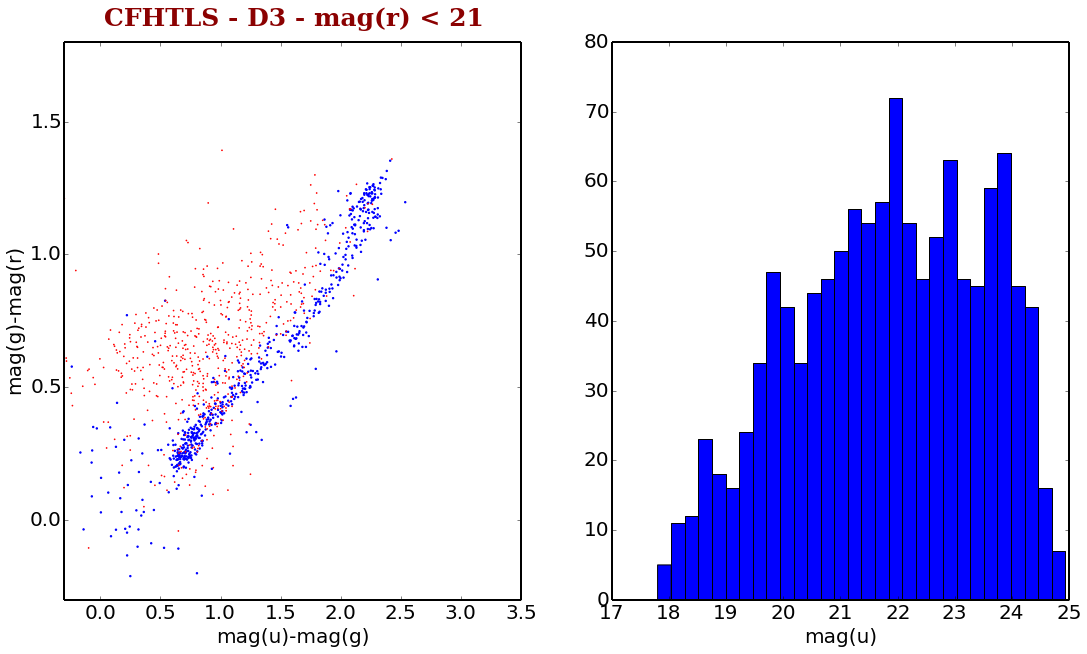

In [15]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'bold',
        'size'   : 25,
        }

mu_s = np.asarray(mu_s)
mu_g = np.asarray(mu_g)
uMinusg_s = np.asarray(uMinusg_s)
gMinusr_s = np.asarray(gMinusr_s)
uMinusg_g = np.asarray(uMinusg_g)
gMinusr_g = np.asarray(gMinusr_g)

idx_s = np.where(mu_s<22)
idx_g = np.where(mu_g<22)

plt.clf()
plt.rcParams['axes.linewidth'] = 2 #set the value globally
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18,10))
ax0.scatter(uMinusg_s[idx_s], gMinusr_s[idx_s], s=2, color='b')
ax0.scatter(uMinusg_g[idx_g], gMinusr_g[idx_g], s=0.5, color='r')
ax0.set_xlim([-0.3,3.5])
ax0.set_ylim([-0.3,1.8])
ax0.set_ylabel("mag(g)-mag(r)", fontsize=20, weight='normal')
ax0.set_xlabel("mag(u)-mag(g)", fontsize=20, weight='normal')
ax0.set_title("CFHTLS - D3 - mag(r) < 21", fontdict=font, y=1.02)
ax0.tick_params(labelsize=20)
plt.rcParams['axes.linewidth'] = 0.5 #set the value globally

ax1.hist(mu_s, bins=30)
ax1.tick_params(labelsize=20)
ax1.set_xlabel("mag(u)", fontsize=20)
plt.show()